# Jupyter Notebook Assignment: Heartbeat Classification with RNN, LSTM, and GRU

## Title: Heartbeat Classification using Sequence Models

### Objective:
In this assignment, you will build, train, and evaluate three different sequence models (RNN, LSTM, GRU) to classify heartbeats based on ECG data. You will compare their performance using metrics such as AUC, F1-score, and accuracy. Additionally, you will explore the data and visualize the results for better understanding.


1. **Dataset Overview:**
   - The dataset contains heartbeat signals derived from two well-known datasets: the MIT-BIH Arrhythmia Dataset and PhysioNet's MIT-BIH Arrhythmia Database.
   - Each row in the dataset is a time series corresponding to one heartbeat, and the signals represent electrocardiogram (ECG) waveforms.
   - The dataset is preprocessed and segmented, with each segment corresponding to a heartbeat. The last column represents the label (5 classes):
     - **'N': 0** - Normal heartbeat
     - **'S': 1** - Supraventricular premature beat
     - **'V': 2** - Premature ventricular contraction
     - **'F': 3** - Fusion of ventricular and normal beat
     - **'Q': 4** - Unclassifiable beat
   - Number of Samples: **109,446**
   - Sampling Frequency: **125 Hz**
   - Training data: `mitbih_train.csv`
   - Testing data: `mitbih_test.csv`
   - Data Source: PhysioNet's MIT-BIH Arrhythmia Dataset

   **Background:**
   - The MIT-BIH Arrhythmia Database includes 48 half-hour excerpts of two-channel ambulatory ECG recordings from 47 subjects, recorded between 1975 and 1979. These recordings were selected to include less common but clinically significant arrhythmias.
   - Each recording was digitized at 360 samples per second per channel, annotated independently by two or more cardiologists.

2. **Assignment Tasks:**

   #### Task 1: Data Exploration
   - Load the data and explore its structure.
   - Plot a few ECG signals for visualization.
   - Check the distribution of classes and identify any imbalance.

   #### Task 2: Model Implementation
   - Implement three sequence models: RNN, LSTM, and GRU.
   - Define the architecture for each model.
   - Train each model on the training dataset.

   #### Task 3: Performance Evaluation
   - Evaluate the performance of each model using:
     - AUC (Area Under the Curve)
     - F1-score
     - Accuracy
   - Generate a confusion matrix for each model.
   - Plot training and testing loss, AUC, F1-score, and accuracy for each epoch.

   #### Task 4: Results Comparison
   - Compare the performance of the three models using tables and plots.
   - Discuss which model performed the best and why.

   #### Task 5: Visualization and Insights
   - Visualize key insights such as class-wise performance, confusion matrix heatmaps, and metric trends over epochs.

3. **Deliverables:**
   - Submit a completed Jupyter Notebook with:
     - Code for all tasks.
     - Plots and visualizations.
     - A short discussion on the results.

4. **Grading Criteria:**
   - Correctness and completeness of the implementation.
   - Quality of visualizations.
   - Depth of analysis in the discussion.

5. **Tips:**
   - Use GPU for faster training.
   - Document your code with comments for better readability.
   - Use libraries like `matplotlib` and `seaborn` for visualizations.

---

## Assignments:

In [40]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
# Load the data
def load_data(train_path, test_path):
    train_data = pd.read_csv(train_path, header=None)
    test_data = pd.read_csv(test_path, header=None)
    
    X_train = train_data.iloc[:, :-1].values
    y_train = train_data.iloc[:, -1].values
    X_test = test_data.iloc[:, :-1].values
    y_test = test_data.iloc[:, -1].values
    
    return X_train, y_train, X_test, y_test

In [42]:
# Dataset class
class HeartbeatDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  # Add input_size dimension
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [43]:
# Data exploration
def explore_data(X_train, y_train):
    # Check data structure
    print("Shape of X_train:", X_train.shape)
    print("Shape of y_train:", y_train.shape)

    # Plot a few ECG signals
    plt.figure(figsize=(12, 6))
    for i in range(5):
        plt.plot(X_train[i], label=f"Signal {i+1}")
    plt.title("Sample ECG Signals")
    plt.xlabel("Time Step")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()

    # Check class distribution
    class_counts = pd.Series(y_train).value_counts()
    plt.figure(figsize=(8, 6))
    sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
    plt.title("Class Distribution")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.show()

In [44]:
# RNN Model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

In [45]:
# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [46]:
# GRU Model
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out

In [47]:
# Training and evaluation functions
def train_model(model, criterion, optimizer, train_loader, device):
    model.train()
    total_loss = 0
    all_preds = []
    all_targets = []
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(y.cpu().numpy())
    
    auc = roc_auc_score(pd.get_dummies(all_targets), pd.get_dummies(all_preds), multi_class='ovr')
    f1 = f1_score(all_targets, all_preds, average='weighted')
    acc = accuracy_score(all_targets, all_preds)
    return total_loss / len(train_loader), auc, f1, acc


def evaluate_model(model, criterion, data_loader, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = criterion(outputs, y)
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(y.cpu().numpy())
    
    auc = roc_auc_score(pd.get_dummies(all_targets), pd.get_dummies(all_preds), multi_class='ovr')
    f1 = f1_score(all_targets, all_preds, average='weighted')
    acc = accuracy_score(all_targets, all_preds)
    return total_loss / len(data_loader), auc, f1, acc

def plot_metrics(train_metrics, test_metrics, epochs):
    plt.figure(figsize=(12, 6))
    for metric_name in train_metrics.keys():
        plt.plot(range(epochs), train_metrics[metric_name], label=f"Train {metric_name}")
        plt.plot(range(epochs), test_metrics[metric_name], label=f"Test {metric_name}", linestyle="--")
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

### Begin analysis

In [60]:
train_path = "mitbih_test.csv"
test_path = "mitbih_train.csv"

# Load data
X_train, y_train, X_test, y_test = load_data(train_path, test_path)

Shape of X_train: (21892, 187)
Shape of y_train: (21892,)


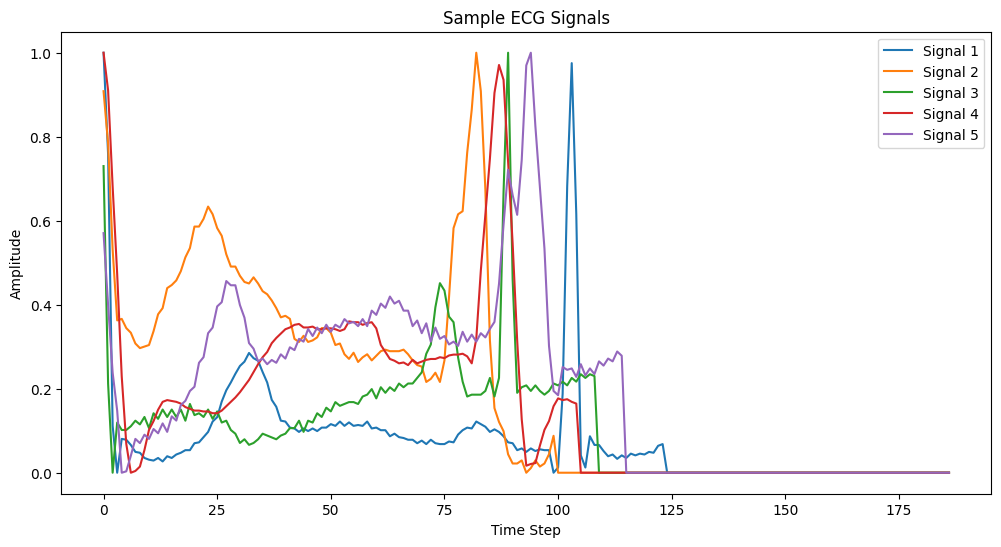

/tmp/ipykernel_1805417/4173448945.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


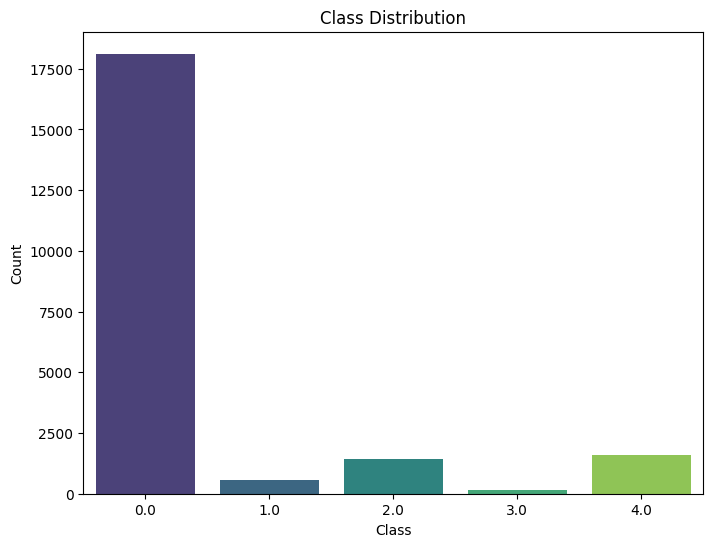

In [62]:
# Explore data
explore_data(X_train, y_train)

Training RNN...
Epoch 1/20: Train Loss: 0.6724, Test Loss: 0.6602, Test AUC: 0.5003, Test F1: 0.7499, Test Acc: 0.8277
Epoch 2/20: Train Loss: 0.6617, Test Loss: 0.6340, Test AUC: 0.5000, Test F1: 0.7497, Test Acc: 0.8277
Epoch 3/20: Train Loss: 0.6270, Test Loss: 0.6215, Test AUC: 0.5000, Test F1: 0.7497, Test Acc: 0.8277
Epoch 4/20: Train Loss: 0.6259, Test Loss: 0.6365, Test AUC: 0.5000, Test F1: 0.7497, Test Acc: 0.8277
Epoch 5/20: Train Loss: 0.6247, Test Loss: 0.6211, Test AUC: 0.5000, Test F1: 0.7497, Test Acc: 0.8277
Epoch 6/20: Train Loss: 0.6239, Test Loss: 0.6226, Test AUC: 0.5000, Test F1: 0.7497, Test Acc: 0.8277
Epoch 7/20: Train Loss: 0.6240, Test Loss: 0.6221, Test AUC: 0.5000, Test F1: 0.7497, Test Acc: 0.8277
Epoch 8/20: Train Loss: 0.6269, Test Loss: 0.6292, Test AUC: 0.5000, Test F1: 0.7497, Test Acc: 0.8277
Epoch 9/20: Train Loss: 0.6248, Test Loss: 0.6231, Test AUC: 0.5000, Test F1: 0.7497, Test Acc: 0.8277
Epoch 10/20: Train Loss: 0.6320, Test Loss: 0.6272, Test 

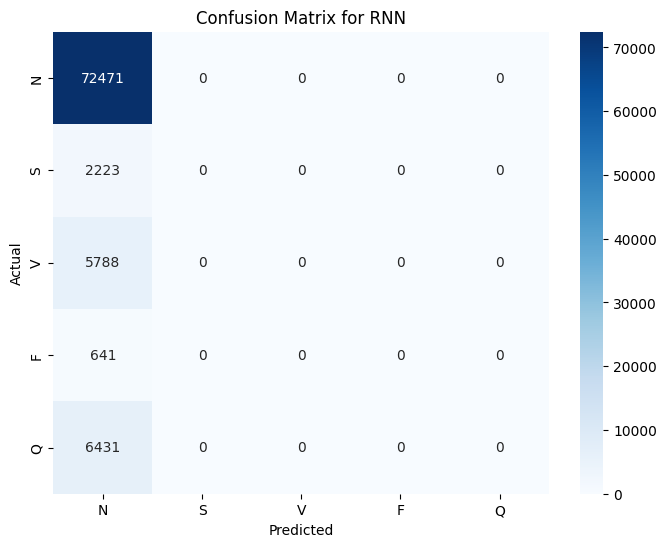

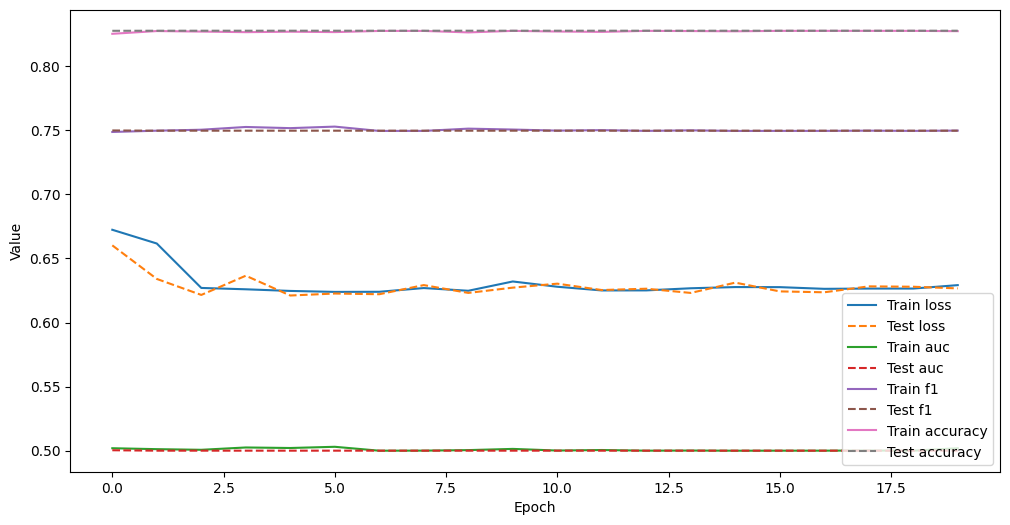

Training LSTM...
Epoch 1/20: Train Loss: 0.6848, Test Loss: 0.6581, Test AUC: 0.5000, Test F1: 0.7497, Test Acc: 0.8277
Epoch 2/20: Train Loss: 0.6530, Test Loss: 0.6486, Test AUC: 0.5079, Test F1: 0.7544, Test Acc: 0.8287
Epoch 3/20: Train Loss: 0.6581, Test Loss: 0.6624, Test AUC: 0.5005, Test F1: 0.7499, Test Acc: 0.8277
Epoch 4/20: Train Loss: 0.6525, Test Loss: 0.6452, Test AUC: 0.5071, Test F1: 0.7530, Test Acc: 0.8282
Epoch 5/20: Train Loss: 0.6346, Test Loss: 0.6393, Test AUC: 0.5001, Test F1: 0.7497, Test Acc: 0.8277
Epoch 6/20: Train Loss: 0.6248, Test Loss: 0.5775, Test AUC: 0.5001, Test F1: 0.7498, Test Acc: 0.8277
Epoch 7/20: Train Loss: 0.5838, Test Loss: 0.5689, Test AUC: 0.5000, Test F1: 0.7497, Test Acc: 0.8277
Epoch 8/20: Train Loss: 0.5977, Test Loss: 0.5612, Test AUC: 0.5144, Test F1: 0.7546, Test Acc: 0.8291
Epoch 9/20: Train Loss: 0.5738, Test Loss: 0.5515, Test AUC: 0.5000, Test F1: 0.7497, Test Acc: 0.8277
Epoch 10/20: Train Loss: 0.5509, Test Loss: 0.6063, Test

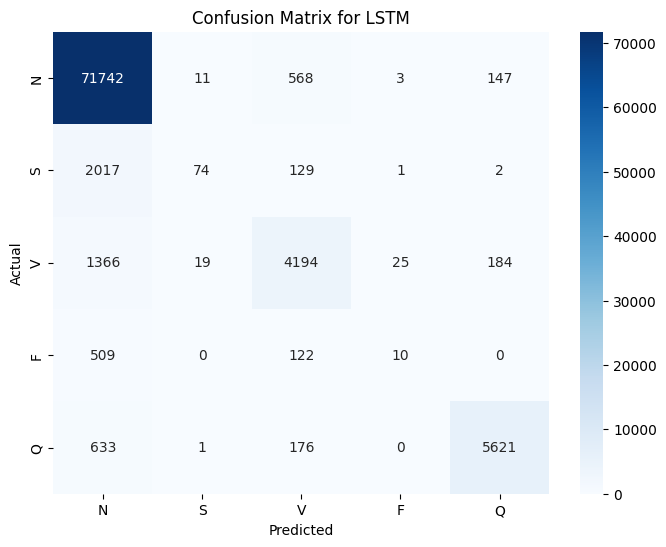

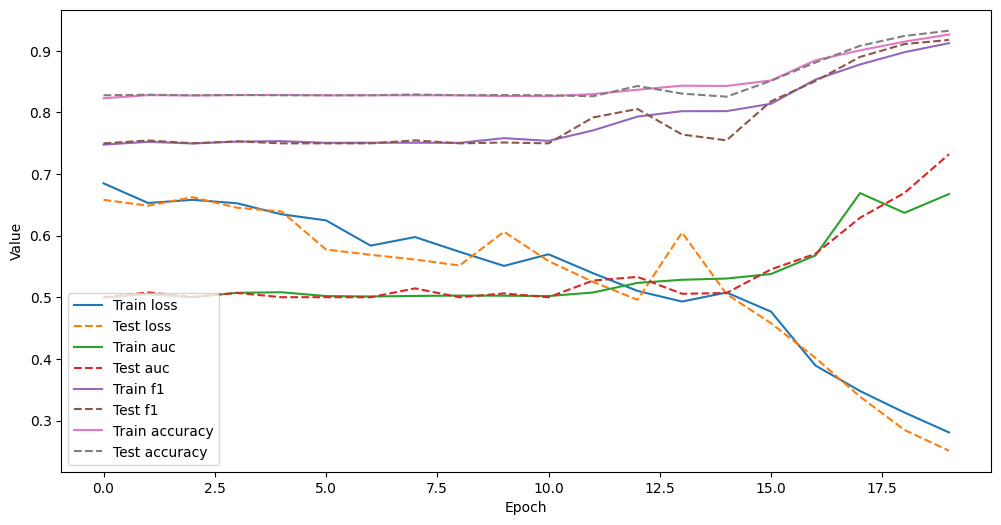

Training GRU...
Epoch 1/20: Train Loss: 0.6322, Test Loss: 0.5690, Test AUC: 0.5955, Test F1: 0.7884, Test Acc: 0.8212
Epoch 2/20: Train Loss: 0.4140, Test Loss: 0.2828, Test AUC: 0.6583, Test F1: 0.9119, Test Acc: 0.9275
Epoch 3/20: Train Loss: 0.2408, Test Loss: 0.2097, Test AUC: 0.6978, Test F1: 0.9327, Test Acc: 0.9440
Epoch 4/20: Train Loss: 0.2020, Test Loss: 0.1899, Test AUC: 0.8000, Test F1: 0.9473, Test Acc: 0.9526
Epoch 5/20: Train Loss: 0.2172, Test Loss: 0.1725, Test AUC: 0.8014, Test F1: 0.9484, Test Acc: 0.9546
Epoch 6/20: Train Loss: 0.1693, Test Loss: 0.1763, Test AUC: 0.8118, Test F1: 0.9485, Test Acc: 0.9536
Epoch 7/20: Train Loss: 0.1623, Test Loss: 0.1519, Test AUC: 0.8104, Test F1: 0.9526, Test Acc: 0.9581
Epoch 8/20: Train Loss: 0.1481, Test Loss: 0.1449, Test AUC: 0.8447, Test F1: 0.9584, Test Acc: 0.9611
Epoch 9/20: Train Loss: 0.1362, Test Loss: 0.1309, Test AUC: 0.8719, Test F1: 0.9627, Test Acc: 0.9650
Epoch 10/20: Train Loss: 0.1320, Test Loss: 0.1264, Test 

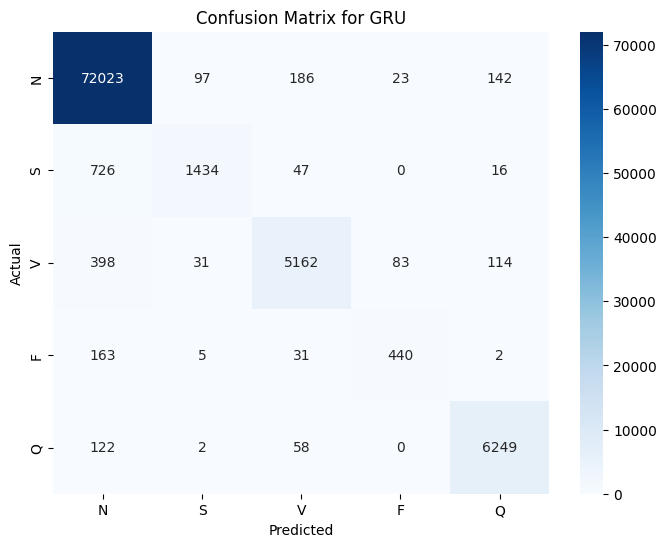

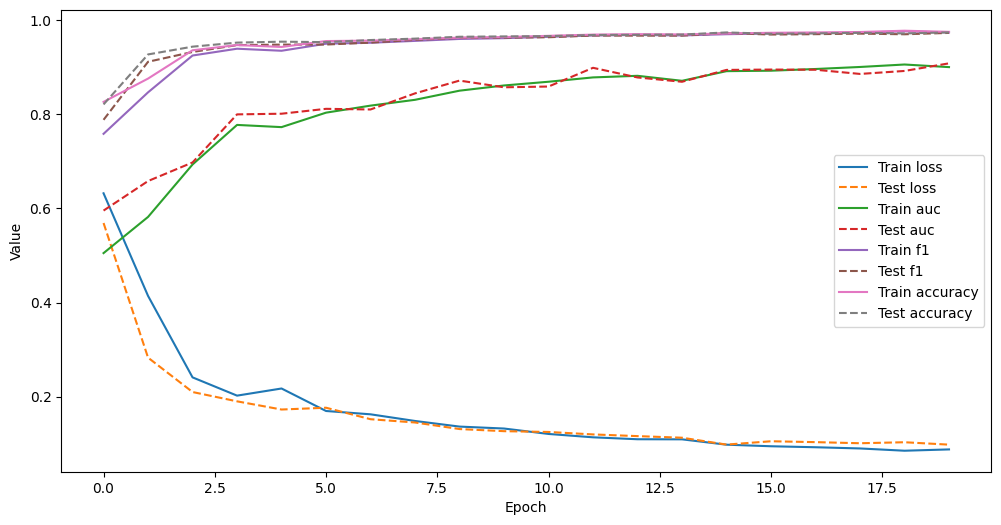

In [63]:
train_dataset = HeartbeatDataset(X_train, y_train)
test_dataset = HeartbeatDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

input_size = 1
hidden_size = 128
num_layers = 2
num_classes = 5
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

models = {
    "RNN": RNNModel(input_size, hidden_size, num_layers, num_classes).to(device),
    "LSTM": LSTMModel(input_size, hidden_size, num_layers, num_classes).to(device),
    "GRU": GRUModel(input_size, hidden_size, num_layers, num_classes).to(device)
}

criterion = nn.CrossEntropyLoss()
results = {}

for model_name, model in models.items():
    print(f"Training {model_name}...")
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_metrics = {"loss": [], "auc": [], "f1": [], "accuracy": []}
    test_metrics = {"loss": [], "auc": [], "f1": [], "accuracy": []}

    for epoch in range(num_epochs):
        train_loss, train_auc, train_f1, train_acc = train_model(model, criterion, optimizer, train_loader, device)
        train_metrics["loss"].append(train_loss)
        train_metrics["auc"].append(train_auc)
        train_metrics["f1"].append(train_f1)
        train_metrics["accuracy"].append(train_acc)

        test_loss, test_auc, test_f1, test_acc = evaluate_model(model, criterion, test_loader, device)
        test_metrics["loss"].append(test_loss)
        test_metrics["auc"].append(test_auc)
        test_metrics["f1"].append(test_f1)
        test_metrics["accuracy"].append(test_acc)

        print(f"Epoch {epoch + 1}/{num_epochs}: Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test AUC: {test_auc:.4f}, Test F1: {test_f1:.4f}, Test Acc: {test_acc:.4f}")

    results[model_name] = (train_metrics, test_metrics)

    # Confusion Matrix
    y_true = []
    y_pred = []
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            preds = torch.argmax(outputs, dim=1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["N", "S", "V", "F", "Q"], yticklabels=["N", "S", "V", "F", "Q"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

    plot_metrics(train_metrics, test_metrics, num_epochs)